In [1]:
!pip install split-folders
import splitfolders
splitfolders.ratio('../input/alzheimer-mri-dataset/Dataset', output="output", seed=1345, ratio=(.7, 0.2,0.1))

Copying files: 6400 files [00:37, 172.15 files/s]


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np, os
from glob import glob
import matplotlib.pyplot as plt

In [3]:
os.listdir('./output')

['val', 'train', 'test']

In [4]:
IMAGE_SIZE = (224, 224)

train_path = './output/train'
valid_path = './output/val'
test_path = './output/test'

In [5]:
folders = glob('./output/train/*')
folders

['./output/train/Moderate_Demented',
 './output/train/Very_Mild_Demented',
 './output/train/Non_Demented',
 './output/train/Mild_Demented']

In [6]:
import os
Moderate_Demented = len(os.listdir(folders[0]))
Very_Mild_Demented = len(os.listdir(folders[1]))
Non_Demented = len(os.listdir(folders[2]))
Mild_Demented = len(os.listdir(folders[3]))
print(f"No of Moderate_Demented files {Moderate_Demented}\nNo of Very_Mild_Demented files {Very_Mild_Demented}\nNo of Non_Demented files {Non_Demented}\nNo of Mild_Demented files {Mild_Demented}")

No of Moderate_Demented files 44
No of Very_Mild_Demented files 1568
No of Non_Demented files 2240
No of Mild_Demented files 627


In [7]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=15,
                                    rescale=1./255,
                                    shear_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 4479 images belonging to 4 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale = 1./255)
val_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle = True)

Found 1279 images belonging to 4 classes.


In [9]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 642 images belonging to 4 classes.


In [10]:
engine = tf.keras.applications.Xception(
        # Freezing the weights of the top layer in the InceptionResNetV2 pre-traiined model
        include_top = False,
        # Use Imagenet weights
        weights = 'imagenet',
        # Define input shape to 224x224x3
        input_shape = (224 , 224 , 3),
    )

2022-11-09 19:28:05.275275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 19:28:05.371100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 19:28:05.371862: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 19:28:05.373527: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 0s 0us/step


In [11]:
x = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(engine.output)
x = tf.keras.layers.Dropout(0.75)(x)
x = tf.keras.layers.BatchNormalization(
                      axis=-1,
                      momentum=0.99,
                      epsilon=0.01,
                      center=True,
                      scale=True,
                      beta_initializer="zeros",
                      gamma_initializer="ones",
                      moving_mean_initializer="zeros",
                      moving_variance_initializer="ones",
                  )(x)
prediction = Dense(len(folders), activation = 'softmax', name = 'dense_output')(x)
 # Build the Keras model
model = Model(inputs = engine.input, outputs = prediction)

In [12]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  # optimizer='adam',
  optimizer= Adam(learning_rate=0.001),
  metrics=['accuracy']
)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=5,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.000001)
reduce_lr =  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.00001)

In [15]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=val_set,
  epochs=100,
  callbacks=[early_stopping, reduce_lr , learning_rate_reduction]
)

2022-11-09 19:28:10.436266: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-11-09 19:28:15.635667: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


140/140 [==============================] - 82s 505ms/step - loss: 1.0259 - accuracy: 0.5253 - val_loss: 8.7160 - val_accuracy: 0.5027
Epoch 2/100
140/140 [==============================] - 68s 486ms/step - loss: 0.8749 - accuracy: 0.5758 - val_loss: 5.4978 - val_accuracy: 0.5043
Epoch 3/100
140/140 [==============================] - 68s 481ms/step - loss: 0.8319 - accuracy: 0.6015 - val_loss: 3.8996 - val_accuracy: 0.5106
Epoch 4/100
140/140 [==============================] - 68s 483ms/step - loss: 0.7859 - accuracy: 0.6437 - val_loss: 2.5445 - val_accuracy: 0.6224
Epoch 5/100
140/140 [==============================] - 68s 486ms/step - loss: 0.7589 - accuracy: 0.6566 - val_loss: 1.4027 - val_accuracy: 0.5966
Epoch 6/100
140/140 [==============================] - 68s 483ms/step - loss: 0.7048 - accuracy: 0.6957 - val_loss: 7.4553 - val_accuracy: 0.3995
Epoch 7/100
140/140 [==============================] - 68s 485ms/step - loss: 0.6420 - accuracy: 0.7247 - val_loss: 1.0380 - val_accurac

In [29]:
import matplotlib.pyplot as plt

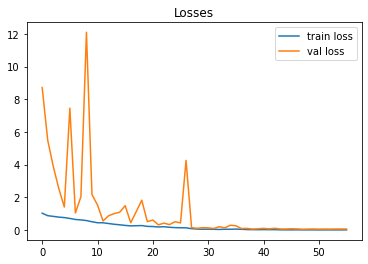

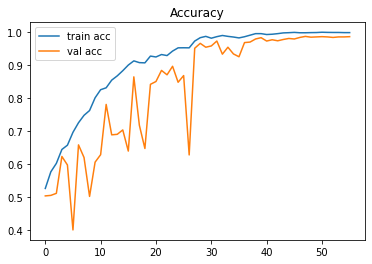

<Figure size 432x288 with 0 Axes>

In [30]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')
plt.show()
plt.savefig('LossVal_loss')
print()
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()
plt.savefig('AccVal_acc')

In [31]:
# average training accuracy
np.mean(r.history['accuracy'])

0.9090318296636853

In [32]:
# val accuracy
model.evaluate(val_set)

40/40 [==============================] - 3s 79ms/step - loss: 0.0574 - accuracy: 0.9859


[0.057427238672971725, 0.9859265089035034]

In [33]:
# test accuracy
model.evaluate(test_set)

21/21 [==============================] - 2s 80ms/step - loss: 0.0829 - accuracy: 0.9829


[0.08287695050239563, 0.9828660488128662]

In [34]:
test_set.class_indices

{'Mild_Demented': 0,
 'Moderate_Demented': 1,
 'Non_Demented': 2,
 'Very_Mild_Demented': 3}

In [35]:
from sklearn.metrics import confusion_matrix, classification_report
prob = model.predict(test_set)
print(prob)

[[9.9997270e-01 3.8631873e-07 2.5735115e-05 1.2084205e-06]
 [9.9981624e-01 7.2662074e-06 5.6839594e-06 1.7085623e-04]
 [8.1072440e-03 1.1701249e-04 4.5219180e-04 9.9132359e-01]
 ...
 [2.0426560e-05 1.9478255e-06 2.3792649e-04 9.9973971e-01]
 [5.2539479e-05 5.5465257e-06 8.9033105e-04 9.9905151e-01]
 [2.3286146e-05 9.9042873e-06 1.3270875e-04 9.9983418e-01]]


In [36]:
predIdxs = np.argmax(prob, axis=1) 

print('\n')
print(classification_report(test_set.labels, predIdxs,target_names = ['Mild_Demented','Moderate_Demented','Non_Demented','Very_Mild_Demented'], digits=5))



                    precision    recall  f1-score   support

     Mild_Demented    0.98864   0.96667   0.97753        90
 Moderate_Demented    0.88889   1.00000   0.94118         8
      Non_Demented    0.98750   0.98750   0.98750       320
Very_Mild_Demented    0.97778   0.98214   0.97996       224

          accuracy                        0.98287       642
         macro avg    0.96070   0.98408   0.97154       642
      weighted avg    0.98304   0.98287   0.98289       642



In [37]:

y_true = test_set.labels
y_pred = predIdxs
cm=confusion_matrix(y_true,y_pred)
cm

array([[ 87,   0,   0,   3],
       [  0,   8,   0,   0],
       [  1,   1, 316,   2],
       [  0,   0,   4, 220]])

Text(69.0, 0.5, 'Predicted Values')

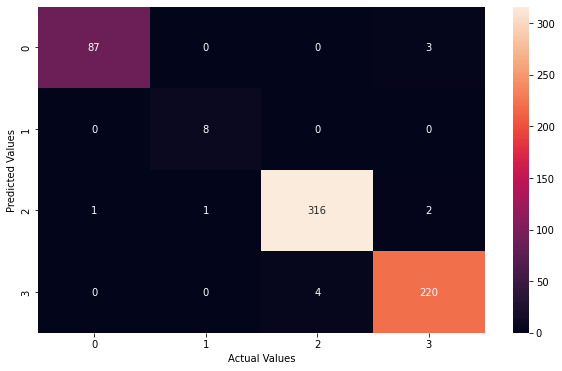

In [38]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

In [39]:
from sklearn.metrics import accuracy_score, f1_score,matthews_corrcoef,make_scorer, precision_score, recall_score, balanced_accuracy_score
score=accuracy_score(y_true,y_pred)
# scorers = {
#             'f1_score': make_scorer(f1_score, average='micro'),
#             # 'precision_score': make_scorer(precision_score, average='micro'),
#             # 'recall_score': make_scorer(recall_score, average='micro'),
#             'accuracy_score': make_scorer(accuracy_score)
# }
f1 = f1_score(y_true, y_pred,  average='micro')
pre = precision_score(y_true, y_pred,  average='micro')
recall = recall_score(y_true, y_pred,  average='micro')
acc = balanced_accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true,y_pred)
# print(f"accuracy {score} f1 {f1} mcc {mcc}")

print(f1, pre, recall, acc,mcc)

0.9828660436137072 0.9828660436137072 0.9828660436137072 0.984077380952381 0.9719178015112392


In [40]:
# # save it as a h5 file
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model.save('Alzheimer_mobilenetV2.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [28]:
os

<module 'os' from '/opt/conda/lib/python3.7/os.py'>